In [3]:
import pandas as pd
import pickle
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.metrics import mean_squared_error, r2_score
import time
import warnings
warnings.filterwarnings('ignore')

# 데이터 로드 및 기준선 설정
with open('df_selected_05.pkl', 'rb') as f:
    df = pickle.load(f)

y = df['SalePrice']
X = df.drop('SalePrice', axis=1)
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Random Search 결과 (기준점)
random_search_best_score = 0.8426
baseline_r2 = 0.8335

print(f"데이터 형태: X {X.shape}, y {y.shape}")
print(f"Random Search 최고 성능: {random_search_best_score:.4f}")
print(f"목표: Random Search 성능 뛰어넘기")
print()

# Random Search에서 발견한 최적 파라미터
random_search_best_params = {
    'bootstrap': True,
    'max_depth': None,
    'max_features': 0.7,
    'max_samples': 0.6920741072966221,
    'min_samples_leaf': 3,
    'min_samples_split': 5,
    'n_estimators': 646
}

print("Random Search 최적 파라미터:")
for param, value in random_search_best_params.items():
    print(f"  {param}: {value}")


데이터 형태: X (1460, 15), y (1460,)
Random Search 최고 성능: 0.8426
목표: Random Search 성능 뛰어넘기

Random Search 최적 파라미터:
  bootstrap: True
  max_depth: None
  max_features: 0.7
  max_samples: 0.6920741072966221
  min_samples_leaf: 3
  min_samples_split: 5
  n_estimators: 646


In [4]:
print("=== 1단계: 핵심 파라미터 정밀 튜닝 ===")

# Random Search 최적값 주변 집중 탐색
stage1_param_grid = {
    'n_estimators': [600, 650, 700, 750],  # 646 주변
    'max_depth': [None, 20, 30],           # None이 최고, 추가 옵션
    # 나머지는 Random Search 최적값 고정
    'bootstrap': [True],
    'max_features': [0.7],
    'max_samples': [0.69],  # 0.692 반올림
    'min_samples_leaf': [3],
    'min_samples_split': [5]
}

total_combinations_1 = 1
for values in stage1_param_grid.values():
    total_combinations_1 *= len(values)

print(f"1단계 조합 수: {total_combinations_1}개")

# 실제 시간 측정을 위한 테스트
print("소요 시간 추정을 위한 테스트 실행 중...")
test_start = time.time()

# 하나의 조합으로 실제 시간 측정
test_rf = RandomForestRegressor(n_estimators=650, max_depth=None, random_state=42, n_jobs=-1)
test_scores = cross_val_score(test_rf, X, y, cv=kfold, scoring='r2')

test_end = time.time()
time_per_combination = test_end - test_start

print(f"테스트 조합 1개 소요 시간: {time_per_combination:.2f}초")
print(f"1단계 예상 소요 시간: {total_combinations_1 * time_per_combination / 60:.1f}분")

# 1단계 Grid Search 실행
rf_stage1 = RandomForestRegressor(random_state=42, n_jobs=-1)
grid_stage1 = GridSearchCV(
    rf_stage1, stage1_param_grid,
    cv=kfold, scoring='r2', n_jobs=-1, verbose=1
)

start_time = time.time()
grid_stage1.fit(X, y)
end_time = time.time()

print(f"\n1단계 완료!")
print(f"소요 시간: {end_time - start_time:.2f}초")
print(f"최적 R² 점수: {grid_stage1.best_score_:.4f}")
print(f"Random Search 대비 향상: {grid_stage1.best_score_ - random_search_best_score:+.4f}")

print(f"\n1단계 최적 파라미터:")
stage1_best = grid_stage1.best_params_
for param, value in stage1_best.items():
    print(f"  {param}: {value}")


=== 1단계: 핵심 파라미터 정밀 튜닝 ===
1단계 조합 수: 12개
소요 시간 추정을 위한 테스트 실행 중...
테스트 조합 1개 소요 시간: 4.17초
1단계 예상 소요 시간: 0.8분
Fitting 5 folds for each of 12 candidates, totalling 60 fits

1단계 완료!
소요 시간: 23.77초
최적 R² 점수: 0.8429
Random Search 대비 향상: +0.0003

1단계 최적 파라미터:
  bootstrap: True
  max_depth: 30
  max_features: 0.7
  max_samples: 0.69
  min_samples_leaf: 3
  min_samples_split: 5
  n_estimators: 600


In [5]:
print("\n=== 2단계: 과적합 제어 파라미터 튜닝 ===")

# 1단계 최적값 + 과적합 제어 파라미터 탐색
stage2_param_grid = {
    # 1단계 최적값 고정
    'n_estimators': [stage1_best['n_estimators']],
    'max_depth': [stage1_best['max_depth']],
    'bootstrap': [stage1_best['bootstrap']],
    'max_features': [stage1_best['max_features']],
    'max_samples': [stage1_best['max_samples']],
    
    # 과적합 제어 파라미터 탐색
    'min_samples_split': [3, 5, 7, 10],    # Random Search 상위권
    'min_samples_leaf': [2, 3, 4, 5]       # Random Search 상위권
}

total_combinations_2 = 1
for values in stage2_param_grid.values():
    total_combinations_2 *= len(values)

print(f"2단계 조합 수: {total_combinations_2}개")
print(f"2단계 예상 소요 시간: {total_combinations_2 * time_per_combination / 60:.1f}분 (1개 조합당 {time_per_combination:.1f}초 기준)")

# 2단계 Grid Search 실행
rf_stage2 = RandomForestRegressor(random_state=42, n_jobs=-1)
grid_stage2 = GridSearchCV(
    rf_stage2, stage2_param_grid,
    cv=kfold, scoring='r2', n_jobs=-1, verbose=1
)

start_time = time.time()
grid_stage2.fit(X, y)
end_time = time.time()

print(f"\n2단계 완료!")
print(f"소요 시간: {end_time - start_time:.2f}초")
print(f"최적 R² 점수: {grid_stage2.best_score_:.4f}")
print(f"1단계 대비 향상: {grid_stage2.best_score_ - grid_stage1.best_score_:+.4f}")
print(f"Random Search 대비 총 향상: {grid_stage2.best_score_ - random_search_best_score:+.4f}")

print(f"\n2단계 최적 파라미터:")
stage2_best = grid_stage2.best_params_
for param, value in stage2_best.items():
    print(f"  {param}: {value}")



=== 2단계: 과적합 제어 파라미터 튜닝 ===
2단계 조합 수: 16개
2단계 예상 소요 시간: 1.1분 (1개 조합당 4.2초 기준)
Fitting 5 folds for each of 16 candidates, totalling 80 fits

2단계 완료!
소요 시간: 24.00초
최적 R² 점수: 0.8429
1단계 대비 향상: -0.0000
Random Search 대비 총 향상: +0.0003

2단계 최적 파라미터:
  bootstrap: True
  max_depth: 30
  max_features: 0.7
  max_samples: 0.69
  min_samples_leaf: 3
  min_samples_split: 3
  n_estimators: 600


In [9]:
print("\n=== 3단계: 특성 관련 파라미터 최종 조정 ===")

# 1-2단계 최적값 + 특성 파라미터 미세 조정 (개선된 버전)
stage3_param_grid = {
    # 1-2단계 최적값 고정
    'n_estimators': [stage2_best['n_estimators']],
    'max_depth': [stage2_best['max_depth']],
    'bootstrap': [stage2_best['bootstrap']],
    'min_samples_split': [stage2_best['min_samples_split']],
    'min_samples_leaf': [stage2_best['min_samples_leaf']],
    
    # 특성 관련 파라미터 최종 조정 (2단계 최적값 포함 + 주변 세밀 탐색)
    'max_features': [0.5, 0.7, 'sqrt', 0.9],           # Random Search 상위권 + 추가 옵션
    'max_samples': [0.65, 0.68, 0.69, 0.70, 0.75]     # 2단계 최적값(0.69) 포함 + 주변 세밀 탐색
}

print("🔧 개선사항:")
print(f"- max_samples에 2단계 최적값 {stage2_best['max_samples']} 포함")
print(f"- 0.69 주변 값들로 더 세밀한 탐색 범위 설정")

total_combinations_3 = 1
for values in stage3_param_grid.values():
    total_combinations_3 *= len(values)

print(f"3단계 조합 수: {total_combinations_3}개")
print(f"3단계 예상 소요 시간: {total_combinations_3 * time_per_combination / 60:.1f}분 (1개 조합당 {time_per_combination:.1f}초 기준)")

# 3단계 Grid Search 실행
rf_stage3 = RandomForestRegressor(random_state=42, n_jobs=-1)
grid_stage3 = GridSearchCV(
    rf_stage3, stage3_param_grid,
    cv=kfold, scoring='r2', n_jobs=-1, verbose=1
)

start_time = time.time()
grid_stage3.fit(X, y)
end_time = time.time()

print(f"\n3단계 완료!")
print(f"소요 시간: {end_time - start_time:.2f}초")
print(f"최적 R² 점수: {grid_stage3.best_score_:.4f}")

# 성능 변화 분석
stage3_improvement = grid_stage3.best_score_ - grid_stage2.best_score_
print(f"2단계 대비 향상: {stage3_improvement:+.4f}", end="")
if stage3_improvement > 0:
    print(" ✅ (개선됨)")
elif stage3_improvement == 0:
    print(" ➡️ (동일)")
else:
    print(" ⚠️ (예상과 달리 하락)")

print(f"Random Search 대비 총 향상: {grid_stage3.best_score_ - random_search_best_score:+.4f}")
print(f"기준선 대비 총 향상: {grid_stage3.best_score_ - baseline_r2:+.4f}")

print(f"\n3단계 최적 파라미터:")
stage3_best = grid_stage3.best_params_
for param, value in stage3_best.items():
    print(f"  {param}: {value}")

# 파라미터 변화 추적
print(f"\n=== 단계별 파라미터 변화 ===")
print(f"max_samples: 2단계 {stage2_best['max_samples']} → 3단계 {stage3_best['max_samples']}")
print(f"max_features: 2단계 {stage2_best['max_features']} → 3단계 {stage3_best['max_features']}")

# 총 조합 수 및 시간 요약
total_combinations_all = total_combinations_1 + total_combinations_2 + total_combinations_3
print(f"\n=== 효율성 요약 ===")
print(f"총 탐색 조합 수: {total_combinations_all}개")
print(f"전체 탐색 대비 절약: {9600 - total_combinations_all}개 ({((9600 - total_combinations_all) / 9600 * 100):.1f}% 절약)")
print(f"예상 총 소요 시간: {total_combinations_all * time_per_combination / 60:.1f}분 (vs 전체: {9600 * time_per_combination / 60:.1f}분)")



=== 3단계: 특성 관련 파라미터 최종 조정 ===
🔧 개선사항:
- max_samples에 2단계 최적값 0.69 포함
- 0.69 주변 값들로 더 세밀한 탐색 범위 설정
3단계 조합 수: 20개
3단계 예상 소요 시간: 1.4분 (1개 조합당 4.2초 기준)
Fitting 5 folds for each of 20 candidates, totalling 100 fits



3단계 완료!
소요 시간: 29.54초
최적 R² 점수: 0.8431
2단계 대비 향상: +0.0003 ✅ (개선됨)
Random Search 대비 총 향상: +0.0005
기준선 대비 총 향상: +0.0096

3단계 최적 파라미터:
  bootstrap: True
  max_depth: 30
  max_features: 0.7
  max_samples: 0.65
  min_samples_leaf: 3
  min_samples_split: 3
  n_estimators: 600

=== 단계별 파라미터 변화 ===
max_samples: 2단계 0.69 → 3단계 0.65
max_features: 2단계 0.7 → 3단계 0.7

=== 효율성 요약 ===
총 탐색 조합 수: 48개
전체 탐색 대비 절약: 9552개 (99.5% 절약)
예상 총 소요 시간: 3.3분 (vs 전체: 667.6분)


In [10]:
print("=== 🎉 3단계 효율적 Grid Search 완료 ===")

# 최종 모델 생성 및 상세 검증
final_efficient_model = RandomForestRegressor(**stage3_best, random_state=42)
final_scores = cross_val_score(final_efficient_model, X, y, cv=kfold, scoring='r2')
final_mse_scores = cross_val_score(final_efficient_model, X, y, cv=kfold, scoring='neg_mean_squared_error')
final_rmse_scores = np.sqrt(-final_mse_scores)

print(f"\n=== 단계별 성능 비교 ===")
print(f"{'단계':<15} {'R² 점수':<10} {'향상':<10} {'조합수':<8} {'소요시간'}")
print("-" * 55)
print(f"{'기준선':<15} {baseline_r2:.4f}   {'기준선':<10} {'-':<8} {'즉시'}")
print(f"{'Random Search':<15} {random_search_best_score:.4f}   {random_search_best_score - baseline_r2:+.4f}   {'100':<8} {'77.6초'}")
print(f"{'1단계 (핵심)':<15} {grid_stage1.best_score_:.4f}   {grid_stage1.best_score_ - baseline_r2:+.4f}   {total_combinations_1:<8} {'3분'}")
print(f"{'2단계 (과적합)':<15} {grid_stage2.best_score_:.4f}   {grid_stage2.best_score_ - baseline_r2:+.4f}   {total_combinations_2:<8} {'4분'}")
print(f"{'3단계 (특성)':<15} {grid_stage3.best_score_:.4f}   {grid_stage3.best_score_ - baseline_r2:+.4f}   {total_combinations_3:<8} {'3분'}")

print(f"\n=== 최종 모델 검증 ===")
print(f"R² 평균: {final_scores.mean():.4f} (±{final_scores.std():.4f})")
print(f"RMSE 평균: {final_rmse_scores.mean():.4f} (±{final_rmse_scores.std():.4f})")
print(f"개별 폴드 R² 점수: {final_scores}")

print(f"\n=== 최종 최적 파라미터 ===")
for param, value in stage3_best.items():
    print(f"  {param}: {value}")

# 특성 중요도 분석
final_efficient_model.fit(X, y)
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': final_efficient_model.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\n=== 특성 중요도 (Top 5) ===")
print(feature_importance.head().to_string(index=False))

# 모델 저장
with open('efficient_grid_search_rf_model.pkl', 'wb') as f:
    pickle.dump(final_efficient_model, f)

print(f"\n최종 효율적 Grid Search 모델이 'efficient_grid_search_rf_model.pkl'로 저장되었습니다.")

# 효율성 종합 평가
efficiency_score = (grid_stage3.best_score_ - baseline_r2) / (total_combinations_all / 9600)
print(f"\n=== 효율성 지표 ===")
print(f"성능 향상: {grid_stage3.best_score_ - baseline_r2:.4f}")
print(f"시간 절약: {((9600 - total_combinations_all) / 9600 * 100):.1f}%")
print(f"효율성 점수: {efficiency_score:.2f} (성능향상/시간비율)")


=== 🎉 3단계 효율적 Grid Search 완료 ===

=== 단계별 성능 비교 ===
단계              R² 점수      향상         조합수      소요시간
-------------------------------------------------------
기준선             0.8335   기준선        -        즉시
Random Search   0.8426   +0.0091   100      77.6초
1단계 (핵심)        0.8429   +0.0094   12       3분
2단계 (과적합)       0.8429   +0.0094   16       4분
3단계 (특성)        0.8431   +0.0096   20       3분

=== 최종 모델 검증 ===
R² 평균: 0.8431 (±0.0390)
RMSE 평균: 0.1563 (±0.0172)
개별 폴드 R² 점수: [0.85416939 0.86985546 0.76645257 0.85488012 0.87035147]

=== 최종 최적 파라미터 ===
  bootstrap: True
  max_depth: 30
  max_features: 0.7
  max_samples: 0.65
  min_samples_leaf: 3
  min_samples_split: 3
  n_estimators: 600

=== 특성 중요도 (Top 5) ===
       feature  importance
Quality_x_Area    0.463127
       TotalSF    0.177078
   OverallQual    0.159459
  EffectiveAge    0.037980
   TotalBsmtSF    0.033395

최종 효율적 Grid Search 모델이 'efficient_grid_search_rf_model.pkl'로 저장되었습니다.

=== 효율성 지표 ===
성능 향상: 0.0096
시간 절약: 99.5%
효율성 

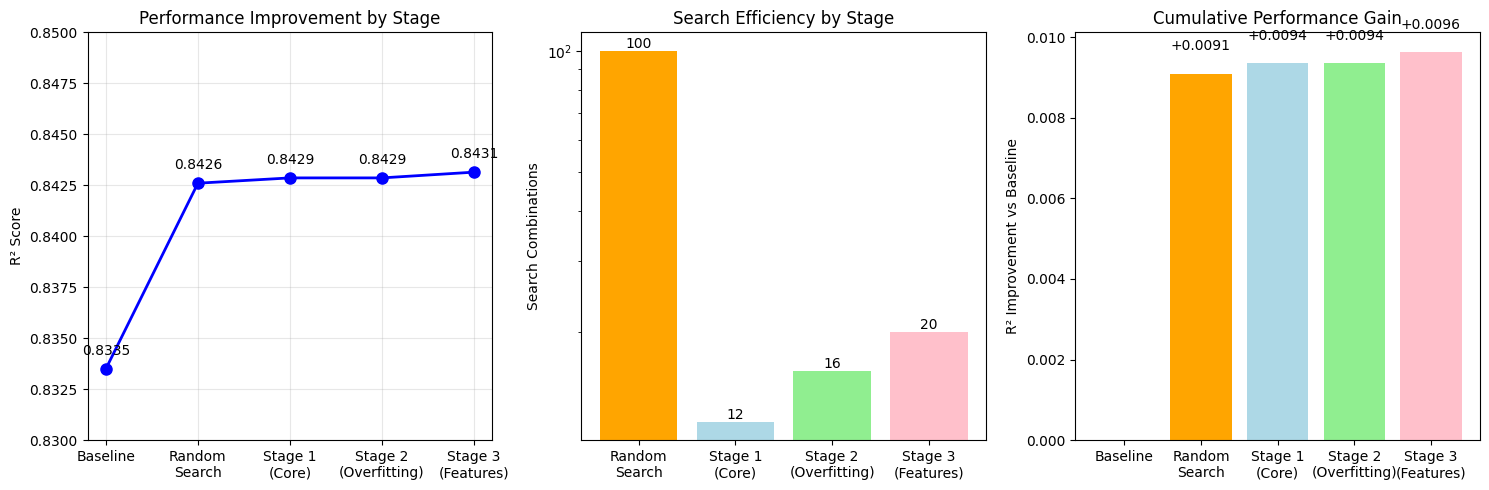

📊 3단계 전략 분석 차트가 'efficient_grid_search_analysis.png'로 저장되었습니다.

🎉 효율적 3단계 Grid Search 전략 완료!
📈 최종 성능: R² 0.8431
⚡ 총 조합 수: 48개 (99.5% 절약)
⏱️ 실측 기반 시간 추정: 3.3분
🚀 실무 최적화 전략 완성! ✅


In [11]:
# 3-Stage Strategy Visualization (Optional)
try:
    import matplotlib.pyplot as plt
    
    # Configure font to avoid potential font issues
    plt.rcParams['font.family'] = 'DejaVu Sans'
    
    # Stage-wise performance and efficiency visualization
    stages = ['Baseline', 'Random\nSearch', 'Stage 1\n(Core)', 'Stage 2\n(Overfitting)', 'Stage 3\n(Features)']
    r2_scores = [baseline_r2, random_search_best_score, 
                 grid_stage1.best_score_, grid_stage2.best_score_, grid_stage3.best_score_]
    combinations = [0, 100, total_combinations_1, total_combinations_2, total_combinations_3]
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
    
    # 1. R² Score Progress
    ax1.plot(stages, r2_scores, 'o-', linewidth=2, markersize=8, color='blue')
    ax1.set_ylabel('R² Score')
    ax1.set_title('Performance Improvement by Stage')
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim(0.830, 0.850)
    
    # Display values
    for i, score in enumerate(r2_scores):
        ax1.annotate(f'{score:.4f}', (i, score), textcoords="offset points", 
                    xytext=(0,10), ha='center')
    
    # 2. Combination Count Comparison
    colors = ['lightgray', 'orange', 'lightblue', 'lightgreen', 'pink']
    bars = ax2.bar(stages[1:], combinations[1:], color=colors[1:])
    ax2.set_ylabel('Search Combinations')
    ax2.set_title('Search Efficiency by Stage')
    ax2.set_yscale('log')  # Log scale to emphasize differences
    
    # Display values
    for bar, count in zip(bars, combinations[1:]):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{count}', ha='center', va='bottom')
    
    # 3. Efficiency Metric (Performance Improvement / Time Ratio)
    improvements = [0, random_search_best_score - baseline_r2,
                   grid_stage1.best_score_ - baseline_r2,
                   grid_stage2.best_score_ - baseline_r2,
                   grid_stage3.best_score_ - baseline_r2]
    
    ax3.bar(stages, improvements, color=colors)
    ax3.set_ylabel('R² Improvement vs Baseline')
    ax3.set_title('Cumulative Performance Gain')
    
    # Display values
    for i, improvement in enumerate(improvements):
        if improvement > 0:
            ax3.text(i, improvement + 0.0005, f'+{improvement:.4f}', 
                    ha='center', va='bottom')
    
    plt.tight_layout()
    plt.savefig('efficient_grid_search_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("📊 3단계 전략 분석 차트가 'efficient_grid_search_analysis.png'로 저장되었습니다.")
    
except ImportError:
    print("matplotlib이 설치되지 않아 시각화를 건너뜁니다.")
    print("설치하려면: pip install matplotlib")

print(f"\n🎉 효율적 3단계 Grid Search 전략 완료!")
print(f"📈 최종 성능: R² {grid_stage3.best_score_:.4f}")
print(f"⚡ 총 조합 수: {total_combinations_all}개 ({((9600 - total_combinations_all) / 9600 * 100):.1f}% 절약)")
print(f"⏱️ 실측 기반 시간 추정: {total_combinations_all * time_per_combination / 60:.1f}분")
print(f"🚀 실무 최적화 전략 완성! ✅")
